# DS CA2
## Task 2
Written by Babak Hosseini Mohtasham 810101408, Parsa Ahmadi 810101609 and Mahdy Naeini 810101536\
Gaining insights from a dataset which focuses on data scientist salaries across different regions from 2020 to 2024.

### Libraries

In [2]:
import pandas as pd
from forex_python.converter import CurrencyRates
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression, SelectKBest
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

### Preprocess

In [3]:
df = pd.read_csv('task2.csv')

df = df.drop_duplicates()

df = df.dropna()

df

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


### Remove data associated with currencies represented fewer than ten times

In [4]:
currency_counts = df['Salary_Currency'].value_counts()
print("before:")
currency_counts

before:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
PLN       7
CHF       6
SGD       6
JPY       4
BRL       4
DKK       3
HUF       3
TRY       3
NOK       2
THB       2
ZAR       1
HKD       1
ILS       1
PHP       1
NZD       1
MXN       1
CLP       1
Name: count, dtype: int64

In [5]:
valid_currencies = currency_counts[currency_counts >= 10].index
df_filtered = df[df['Salary_Currency'].isin(valid_currencies)]

print("after:")
df_filtered['Salary_Currency'].value_counts()

after:


Salary_Currency
USD    7499
GBP     410
EUR     339
INR      52
CAD      48
AUD      12
Name: count, dtype: int64

In [6]:
df_filtered

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,USD,0,Medium
...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,USD,100,Large


### Convert all currencies to USD

In [7]:
currencies = df_filtered['Salary_Currency'].unique()
conversion_rates = {i:{} for i in currencies}

c = CurrencyRates()

for currency in currencies:
    try:
        for year in range(2020,2025):
            conversion_rates[currency][year] = c.get_rate(currency, 'USD', datetime(year, 1, 1))
    except Exception as e:
        print(f"Error fetching conversion rate for {currency}: {e}")

conversion_rates

{'USD': {2020: 1.0, 2021: 1.0, 2022: 1.0, 2023: 1.0, 2024: 1.0},
 'EUR': {2020: 1.1234, 2021: 1.2271, 2022: 1.1326, 2023: 1.0666, 2024: 1.105},
 'GBP': {2020: 1.3204043253408555,
  2021: 1.3649155200605096,
  2022: 1.347884038653782,
  2023: 1.2025751750419988,
  2024: 1.2715033657442034},
 'CAD': {2020: 0.7695574736265242,
  2021: 0.7849421096398644,
  2022: 0.7869103036198152,
  2023: 0.7386426592797785,
  2024: 0.75467832263352},
 'AUD': {2020: 0.7023444826508284,
  2021: 0.7719552088575743,
  2022: 0.7253282100544348,
  2023: 0.6796660931625566,
  2024: 0.6794564348521183},
 'INR': {2020: 0.014009752204222629,
  2021: 0.013686071346914195,
  2022: 0.013446643206868876,
  2023: 0.01209694797609191,
  2024: 0.012023350325609736}}

In [8]:
def convert_to_usd(row):
    amount = row['Salary']
    currency = row['Salary_Currency']
    Work_Year=row['Work_Year']
    try:
        return amount * conversion_rates[currency][Work_Year]
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

df_filtered.insert(5,"Salary_in_USD", df_filtered.apply(convert_to_usd, axis=1))

df_filtered = df_filtered.dropna(subset=['Salary_in_USD'])

df_filtered

,Work_Year,Experience_Level,Employment_Type,Job_Title,Salary,Salary_in_USD,Salary_Currency,Remote_Ratio,Company_Size
0,2024,Senior-Level,Full-Time,AI Engineer,90000,90000.000000,USD,0,Large
1,2024,Senior-Level,Full-Time,Machine Learning Engineer,180500,180500.000000,USD,0,Medium
2,2024,Senior-Level,Full-Time,Machine Learning Engineer,96200,96200.000000,USD,0,Medium
3,2024,Senior-Level,Full-Time,Machine Learning Engineer,235000,235000.000000,USD,0,Medium
4,2024,Senior-Level,Full-Time,Machine Learning Engineer,175000,175000.000000,USD,0,Medium
...,...,...,...,...,...,...,...,...,...
13967,2020,Senior-Level,Full-Time,Data Scientist,412000,412000.000000,USD,100,Large
13968,2021,Mid-Level,Full-Time,Principal Data Scientist,151000,151000.000000,USD,100,Large
13969,2020,Entry-Level,Full-Time,Data Scientist,105000,105000.000000,USD,100,S
13970,2020,Entry-Level,Contract,Business Data Analyst,100000,100000.000000,USD,100,Large


### Jobs with hughest and lowest salary

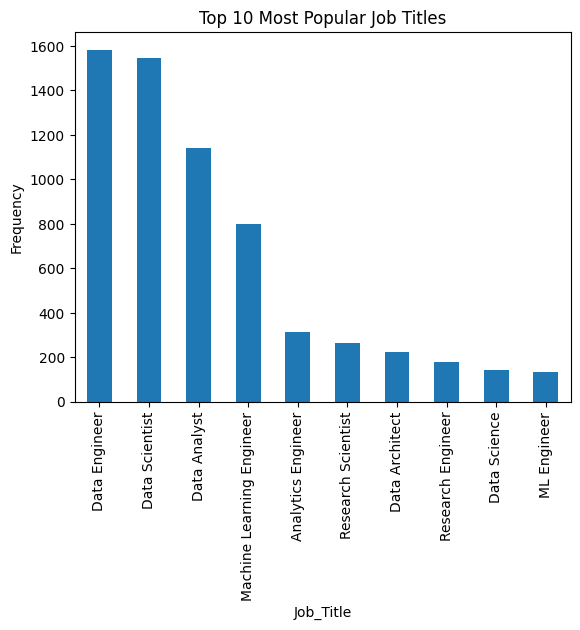

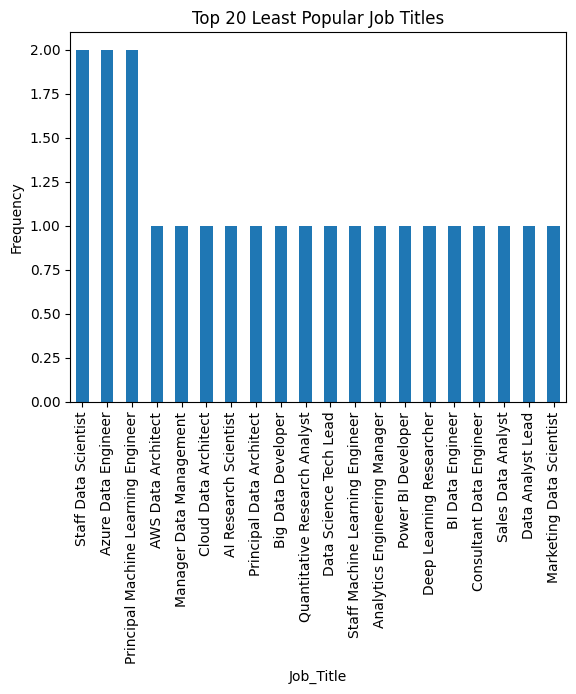

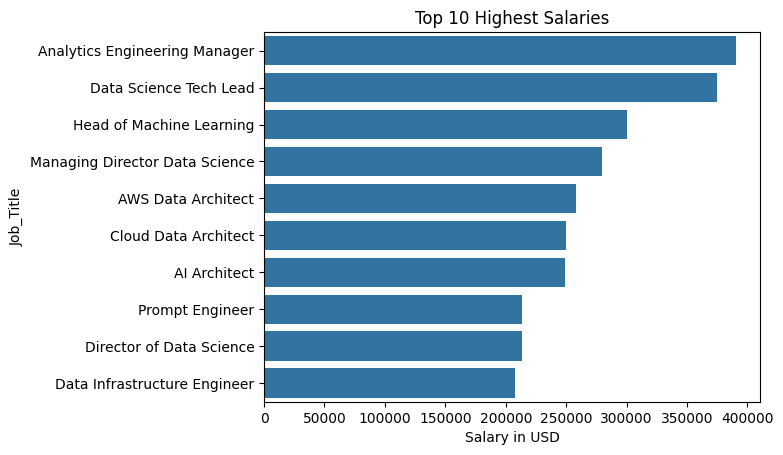

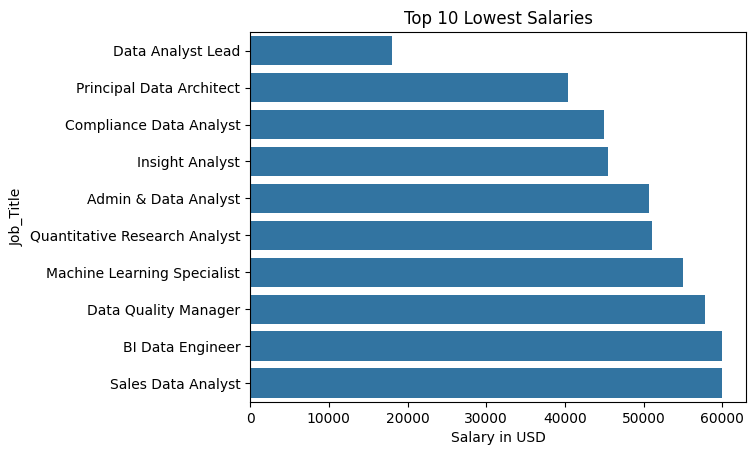

In [9]:
top_titles = df_filtered['Job_Title'].value_counts().head(10)
top_titles.plot(kind='bar')
plt.title('Top 10 Most Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

top_titles = df_filtered['Job_Title'].value_counts().tail(20)
top_titles.plot(kind='bar')
plt.title('Top 20 Least Popular Job Titles')
plt.ylabel('Frequency')
plt.show()

high_salaries = pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean().nlargest(10))
high_salaries['Job_Title'] = high_salaries.index
sns.barplot(x='Salary_in_USD', y='Job_Title', data=high_salaries)
plt.title('Top 10 Highest Salaries')
plt.xlabel('Salary in USD')
plt.show()

low_salaries = pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean().nsmallest(10))
low_salaries['Job_Title'] = low_salaries.index
sns.barplot(x='Salary_in_USD', y='Job_Title', data=low_salaries)
plt.title('Top 10 Lowest Salaries')
plt.xlabel('Salary in USD')
plt.show()

In [10]:
job_salary_mean=pd.DataFrame(df_filtered.groupby(['Job_Title'])['Salary_in_USD'].mean())
job_salary_mean['Job_Title']=job_salary_mean.index
def salary_times_frequency(row):
    salary = row['Salary_in_USD']
    frequency = df_filtered['Job_Title'].value_counts()[row['Job_Title']]
    try:
        return salary * frequency
    except KeyError:
        print(f"Conversion rate for {currency} not found.")
        return None

job_salary_mean.apply(salary_times_frequency,axis=1).nlargest(10)

Job_Title
Data Scientist               2.319952e+08
Data Engineer                2.316654e+08
Machine Learning Engineer    1.428174e+08
Data Analyst                 1.240895e+08
Analytics Engineer           5.082692e+07
Research Scientist           5.046809e+07
Data Architect               3.677814e+07
Research Engineer            3.234211e+07
ML Engineer                  2.685784e+07
Data Science                 2.271944e+07
dtype: float64

## Correlation between any two feature

### Use ttest to reject different null hypotheses

In [11]:
def print_t_test_results(group_col,target_col,group1_category, group2_category, alternative):
    group1 = df_filtered[df_filtered[group_col] == group1_category][target_col]
    group2 = df_filtered[df_filtered[group_col] == group2_category][target_col]
    def _remove__from_string(s):
        return ' '.join(s.split('_'))
    group_col = _remove__from_string(str(group_col))
    target_col = _remove__from_string(str(target_col))
    group1_category = _remove__from_string(str(group1_category))
    group2_category = _remove__from_string(str(group2_category))
    if alternative == 'two-sided':
        print(
            f"t-test: {target_col} for {group_col} {group1_category} is different from {group2_category}: {stats.ttest_ind(group1, group2, equal_var=True, alternative=alternative)}")
    else:
        print(
            f"t-test: {target_col} for {group_col} {group1_category} is {alternative} than {group2_category}: {stats.ttest_ind(group1, group2, equal_var=True, alternative=alternative)}")

We can say the more expereinced a data scientist is the more salary he/she would get.

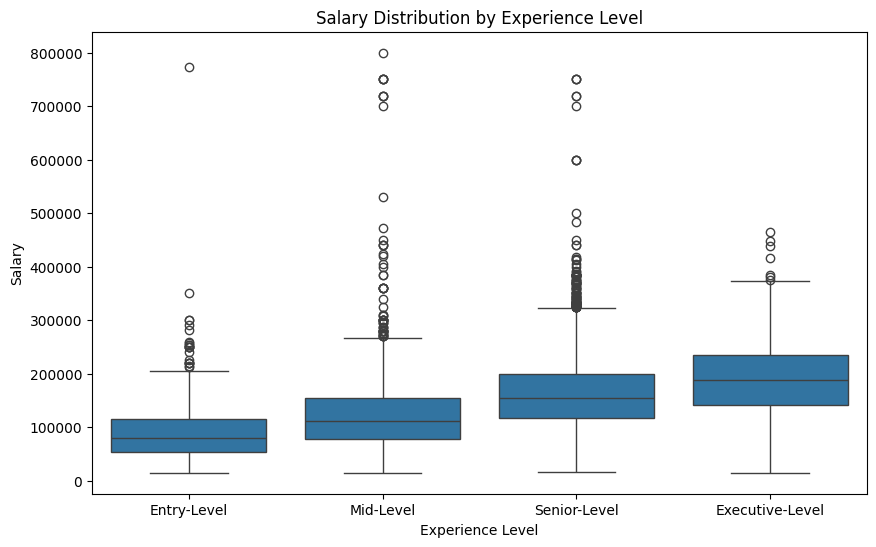

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Experience_Level', y='Salary_in_USD', data=df_filtered, order=['Entry-Level', 'Mid-Level', 'Senior-Level', 'Executive-Level'])
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.show()




In [13]:
print_t_test_results('Experience_Level', 'Salary_in_USD', 'Entry-Level', 'Mid-Level', 'less')
print_t_test_results('Experience_Level', 'Salary_in_USD', 'Mid-Level', 'Senior-Level', 'less')
print_t_test_results('Experience_Level', 'Salary_in_USD', 'Senior-Level', 'Executive-Level', 'less')

t-test: Salary in USD for Experience Level Entry-Level is less than Mid-Level: TtestResult(statistic=-12.18029174550241, pvalue=1.1802307397721207e-33, df=3025.0)
t-test: Salary in USD for Experience Level Mid-Level is less than Senior-Level: TtestResult(statistic=-22.476590379720548, pvalue=1.6521013002263774e-108, df=7242.0)
t-test: Salary in USD for Experience Level Senior-Level is less than Executive-Level: TtestResult(statistic=-7.478898027517608, pvalue=4.357700662169821e-14, df=5331.0)


Based on the dataset, the data scientists with salaries in USD get more salary than data scientist who get salary in other currencies. We think mostly USA would give salaries in USD and we can hypothesis that data scientists get more salary in USA than other countries. Furthermore, we can al see that Canada has the highest salary after USA next it is Austrailia and Britain and lastly Europe and India.

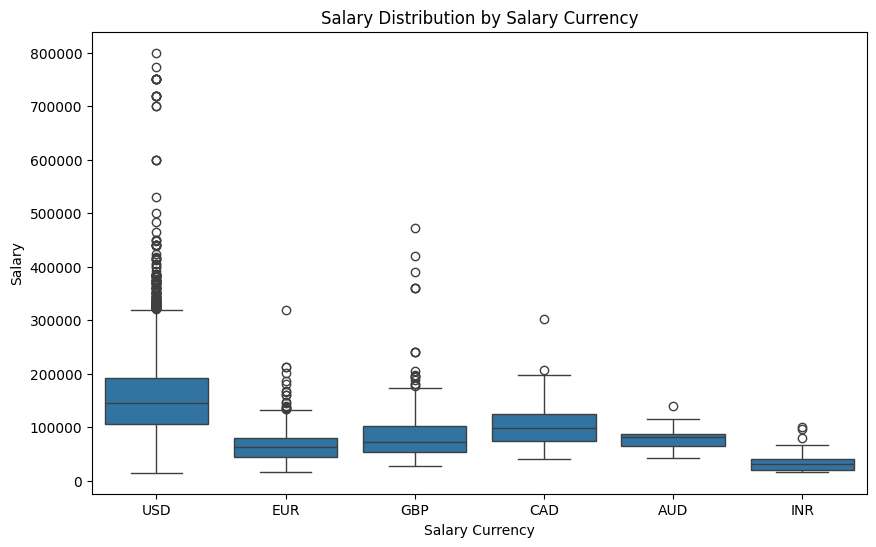

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Salary_Currency', y='Salary_in_USD', data=df_filtered, order=currencies)
plt.title('Salary Distribution by Salary Currency')
plt.xlabel('Salary Currency')
plt.ylabel('Salary')
plt.show()

In [15]:
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'USD', 'CAD', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'CAD', 'AUD', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'CAD', 'GBP', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'AUD', 'INR', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'AUD', 'EUR', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'GBP', 'INR', 'greater')
print_t_test_results('Salary_Currency', 'Salary_in_USD', 'GBP', 'EUR', 'greater')

t-test: Salary in USD for Salary Currency USD is greater than CAD: TtestResult(statistic=4.575622473990568, pvalue=2.4119796722404327e-06, df=7545.0)
t-test: Salary in USD for Salary Currency CAD is greater than AUD: TtestResult(statistic=1.7954491572655389, pvalue=0.03889611323743555, df=58.0)
t-test: Salary in USD for Salary Currency CAD is greater than GBP: TtestResult(statistic=2.889928248522954, pvalue=0.0020185308092603707, df=456.0)
t-test: Salary in USD for Salary Currency AUD is greater than INR: TtestResult(statistic=6.654976322359873, pvalue=4.23699526321573e-09, df=62.0)
t-test: Salary in USD for Salary Currency AUD is greater than EUR: TtestResult(statistic=1.2571526738478414, pvalue=0.10476950400394117, df=349.0)
t-test: Salary in USD for Salary Currency GBP is greater than INR: TtestResult(statistic=6.7964233936327725, pvalue=1.66793117611371e-11, df=460.0)
t-test: Salary in USD for Salary Currency GBP is greater than EUR: TtestResult(statistic=5.1303942379157865, pvalue

Another finding is that type of emplyment is correlated with the salary. Full time data scientist are paid more than contract employees who are paid more than part time emplyees who are paid more than freelancers.

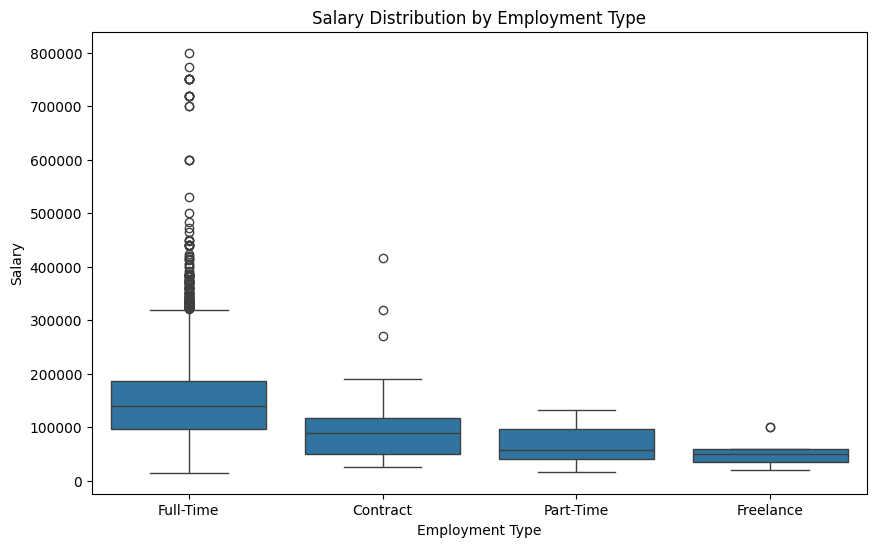

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Employment_Type', y='Salary_in_USD', data=df_filtered, order=df_filtered['Employment_Type'].unique())
plt.title('Salary Distribution by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Salary')
plt.show()

In [17]:
print_t_test_results('Employment_Type', 'Salary_in_USD', 'Freelance', 'Part-Time', 'less')
print_t_test_results('Employment_Type', 'Salary_in_USD', 'Part-Time', 'Contract', 'less')
print_t_test_results('Employment_Type', 'Salary_in_USD', 'Contract', 'Full-Time', 'less')

t-test: Salary in USD for Employment Type Freelance is less than Part-Time: TtestResult(statistic=-1.2552920104385408, pvalue=0.10969701999259641, df=29.0)
t-test: Salary in USD for Employment Type Part-Time is less than Contract: TtestResult(statistic=-1.8493945191927634, pvalue=0.035723283551833185, df=42.0)
t-test: Salary in USD for Employment Type Contract is less than Full-Time: TtestResult(statistic=-2.472999238315218, pvalue=0.006709127719090358, df=8327.0)


Medium sized companies give the highest salary while large companies give more salary than small ones. We think a reason for this may be due to the fact that many large companies are a subset of medium sized companies like Google is a subset of Alphabet and the CEOs and higher ranks of google and other subcompanies employees get their salary from alphabet which is more than the salary smaller and larger companies pay.

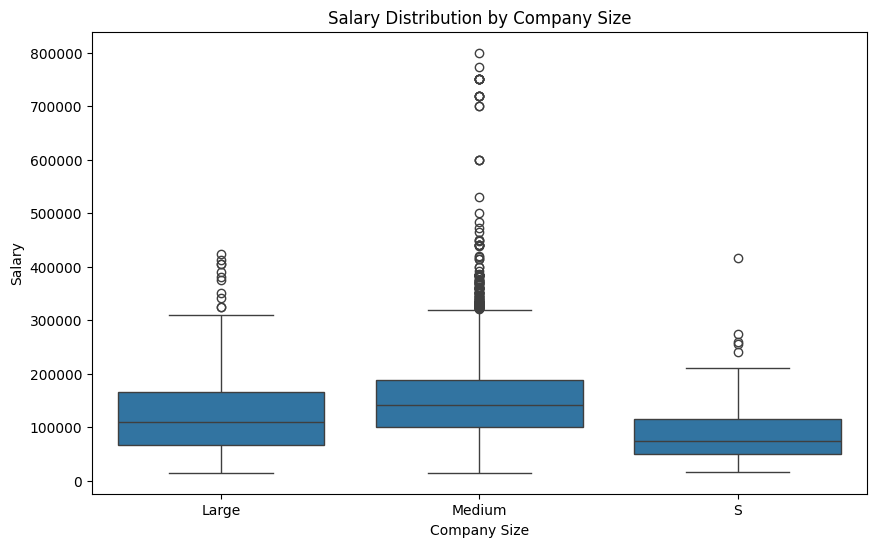

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Company_Size', y='Salary_in_USD', data=df_filtered, order=df_filtered['Company_Size'].unique())
plt.title('Salary Distribution by Company Size')
plt.xlabel('Company Size')
plt.ylabel('Salary')
plt.show()

In [19]:
print_t_test_results('Company_Size', 'Salary_in_USD', 'Medium', 'S', 'greater')
print_t_test_results('Company_Size', 'Salary_in_USD', 'Medium', 'Large', 'greater')
print_t_test_results('Company_Size', 'Salary_in_USD', 'Large', 'S', 'greater')

t-test: Salary in USD for Company Size Medium is greater than S: TtestResult(statistic=10.771396109776516, pvalue=3.633171692252834e-27, df=7773.0)
t-test: Salary in USD for Company Size Medium is greater than Large: TtestResult(statistic=8.537980694884093, pvalue=8.059337006215129e-18, df=8193.0)
t-test: Salary in USD for Company Size Large is greater than S: TtestResult(statistic=5.462161953731759, pvalue=3.20374833855686e-08, df=748.0)


The data scientists who don't work remotely get higher salary than the ones who work remotely and those who work remotely get higher salary than those who work hybrid.

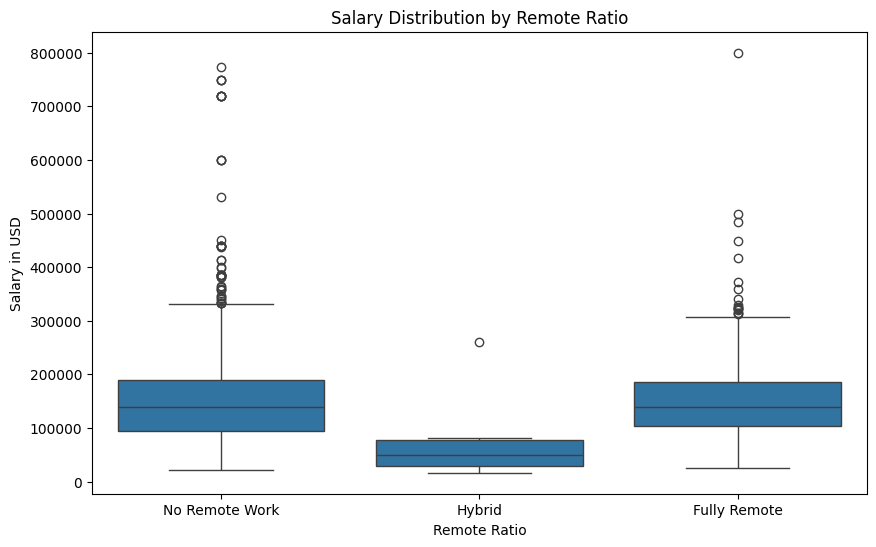

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Remote_Ratio', y='Salary_in_USD', data=df_filtered)
plt.title('Salary Distribution by Remote Ratio')
plt.xlabel('Remote Ratio')
plt.ylabel('Salary in USD')
plt.xticks(ticks=[0, 1, 2], labels=['No Remote Work', 'Hybrid', 'Fully Remote'])
plt.show()

In [36]:
print_t_test_results('Remote_Ratio', 'Salary_in_USD', 50, 0, 'less')
print_t_test_results('Remote_Ratio', 'Salary_in_USD', 50, 100, 'less')
print_t_test_results('Remote_Ratio', 'Salary_in_USD', 0, 100, 'greater')

t-test: Salary in USD for Remote Ratio 50 is less than 0: TtestResult(statistic=-12.91179475309914, pvalue=6.964259347911467e-38, df=5371.0)
t-test: Salary in USD for Remote Ratio 50 is less than 100: TtestResult(statistic=-12.478165742116106, pvalue=3.1481668147230745e-35, df=3201.0)
t-test: Salary in USD for Remote Ratio 0 is greater than 100: TtestResult(statistic=5.226725006142317, pvalue=8.841047868056434e-08, df=8142.0)


Data scientists usually work remotely for smaller companies. Also they work more remotely for larger companies than medium sized companies.

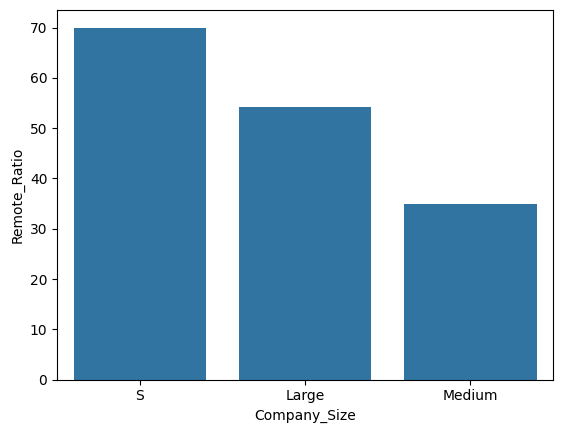

In [107]:
high_salaries = pd.DataFrame(df_filtered.groupby(['Company_Size'])['Remote_Ratio'].mean().nlargest(10))
sns.barplot(x='Company_Size', y='Remote_Ratio', data=high_salaries)
plt.show()

In [101]:
print_t_test_results('Company_Size', 'Remote_Ratio', 'Medium', 'Large', 'less')
print_t_test_results('Company_Size', 'Remote_Ratio', 'Large', 'S', 'less')

t-test: Remote Ratio for Company Size Medium is less than Large: TtestResult(statistic=-9.516660685615864, pvalue=1.1526477155160957e-21, df=8193.0)
t-test: Remote Ratio for Company Size Large is less than S: TtestResult(statistic=-4.1337783291717995, pvalue=1.9861412723758153e-05, df=748.0)


We can see not working hybrid has more impact on salary than the size of the company a data scientist works in.

In [31]:
pd.DataFrame(df_filtered.groupby(['Company_Size','Remote_Ratio'])['Salary_in_USD'].mean().sort_values(ascending=False))

Salary_in_USD
Company_Size Remote_Ratio               
Medium       0             152720.943588
Large        0             149286.444427
Medium       100           147866.103353
Large        100           121003.674020
S            0             103330.893876
Large        50             91174.897932
S            100            87018.555356
             50             81050.598169
Medium       50             72120.433169

We think the due to the global pandemic many data scientists worked remotely 2020 to 2022.

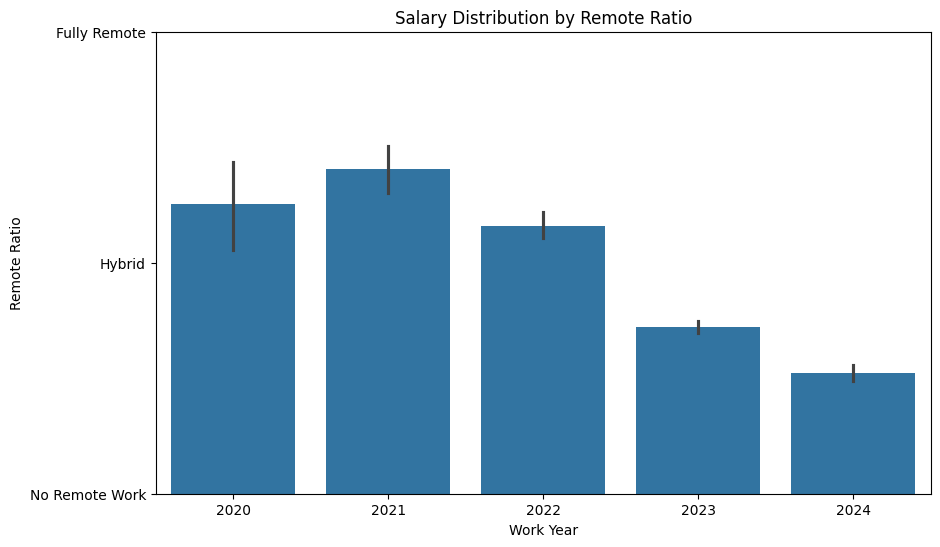

In [76]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Work_Year', y='Remote_Ratio', data=df_filtered,estimator='mean')
plt.title('Salary Distribution by Remote Ratio')
plt.xlabel('Work Year')
plt.ylabel('Remote Ratio')
plt.yticks(ticks=[0, 50, 100], labels=['No Remote Work', 'Hybrid', 'Fully Remote'])
plt.show()

In [73]:
print_t_test_results('Work_Year', 'Remote_Ratio', 2022, 2023, 'greater')
print_t_test_results('Work_Year', 'Remote_Ratio', 2023, 2024, 'greater')

t-test: Remote Ratio for Work Year 2022 is greater than 2023: TtestResult(statistic=13.602161340810683, pvalue=8.876580761419333e-42, df=5573.0)
t-test: Remote Ratio for Work Year 2023 is greater than 2024: TtestResult(statistic=8.616501448723403, pvalue=4.219269577849866e-18, df=6996.0)


We've found out the salary of 2023 and 2024 have been greater than 2022 which is greater than 2021 and 2020. There are several reasons why that is the case, here are a few:
* We think one of the most important reasons for this increase form 2021 to 2023 and not much change from 2020 to 2021 and 2023 to 2024 is due to the COVID-19 pandemic. Although this hypothesis sounds very probable, without ahving the dataset for years before 2020 we can't be sure.
* Another reason may be increase in demand for data scientists. After release of ChatGpt and other generative machine learning models, many companies are looking for data scientists.
* Other finantial reasons like inflation and ....

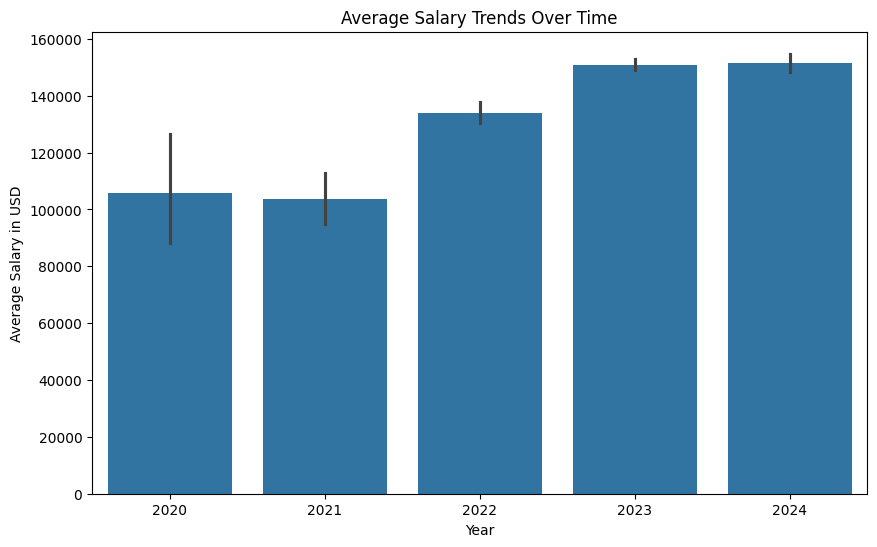

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Work_Year', y='Salary_in_USD', data=df_filtered, estimator='mean')
plt.title('Average Salary Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Average Salary in USD')
plt.show()

In [37]:
print_t_test_results('Work_Year', 'Salary_in_USD', 2020, 2021, 'two-sided')
print_t_test_results('Work_Year', 'Salary_in_USD', 2021, 2022, 'less')
print_t_test_results('Work_Year', 'Salary_in_USD', 2022, 2023, 'less')
print_t_test_results('Work_Year', 'Salary_in_USD', 2023, 2024, 'two-sided')

t-test: Salary in USD for Work Year 2020 is different from 2021: TtestResult(statistic=0.22146363028939106, pvalue=0.8248982342707014, df=271.0)
t-test: Salary in USD for Work Year 2021 is less than 2022: TtestResult(statistic=-6.415761891403011, pvalue=9.816856754709431e-11, df=1289.0)
t-test: Salary in USD for Work Year 2022 is less than 2023: TtestResult(statistic=-7.374883460173902, pvalue=9.428817580911487e-14, df=5573.0)
t-test: Salary in USD for Work Year 2023 is different from 2024: TtestResult(statistic=-0.37895762141052325, pvalue=0.7047308341933967, df=6996.0)
